## Xsurv

The data come from the publication of the R package Xsurv for prognostic biomarker discovery with high-dimensional features and survival outcomes. It contains 320 patients with 3 clinical covariates (sex, age, and metastatic melanoma stage) and 197 filtered methylation CpG sites. The objective is to identify CpG sites with prognostic values. 

The target is the melanoma stage, which is binarized and encoded as follow:
 * 1: low stage group
 * 2: high stage group


> See more information at *Efficient gradient boosting for prognostic biomarker discovery* (https://doi.org/10.1093/bioinformatics/btab869 and https://github.com/wanglab1/Xsurv).



In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("/Users/subasrees/Desktop/intermediate-machine-learning-training/data/Xsurv.csv", index_col=0)
df.head()

,SEX,AGE,Stage,cg27248148,cg12058490,cg00241712,cg16118089,cg01654582,cg19291355,cg06050065,...,cg14781605,cg04983151,cg08185798,cg23960088,cg25229172,cg09709592,cg16523801,cg15794034,cg13640200,cg07294263
1,2,53,1,0.688097,0.897329,1.019083,-0.924499,-1.127179,-1.281784,0.988680,...,0.735094,-0.471669,-0.707190,0.725518,-1.092426,0.219400,0.924476,0.584913,0.602759,-0.784221
2,2,64,1,-0.167593,0.187312,0.420220,-0.332361,-0.994588,-1.301198,0.984446,...,-0.662482,0.605492,-0.021156,1.264888,-0.039521,0.673367,0.987526,-0.181029,-0.585994,0.197806
3,2,64,2,-0.107404,0.876143,0.207461,-0.462419,-0.970031,-1.159380,0.864928,...,-0.220887,1.255080,0.419770,0.956803,-0.252576,0.613774,0.858919,0.057747,-0.389359,-0.043192
21,1,22,2,0.224873,0.704260,0.027405,-0.663955,-0.944272,-1.235145,0.976426,...,-0.007617,0.730081,0.639056,1.142790,-0.648752,0.480485,0.916909,-0.516643,-0.611523,0.259414
28,1,61,2,-0.383246,-0.067605,0.187677,-0.301763,-1.227389,-1.332657,0.755529,...,0.080295,-0.076832,-0.934310,1.179199,-0.838930,0.747185,0.651451,0.586711,-0.714334,-0.483034


In [3]:
df.shape

(320, 200)

In [4]:
X = df.drop(columns=['Stage'])
y = df.Stage

In [5]:
y.value_counts()

Stage
2    163
1    157
Name: count, dtype: int64

As we can see, a few columns are highly correlated (>0.9)

Text(0, 0.5, 'explained variance ratio')

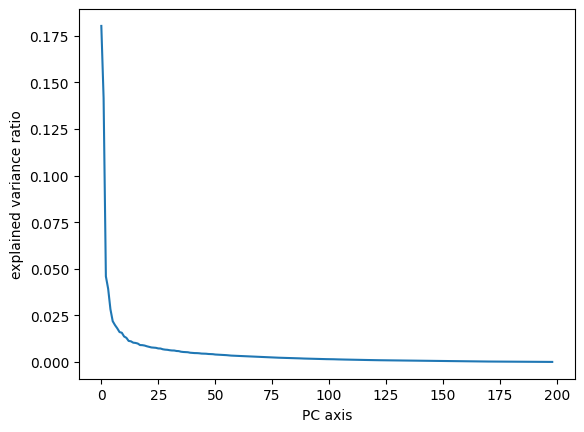

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
sc = StandardScaler()
pca = PCA()

x_pca = pca.fit_transform( sc.fit_transform(X) )


plt.plot( pca.explained_variance_ratio_ )
plt.xlabel("PC axis")
plt.ylabel("explained variance ratio")

<Axes: >

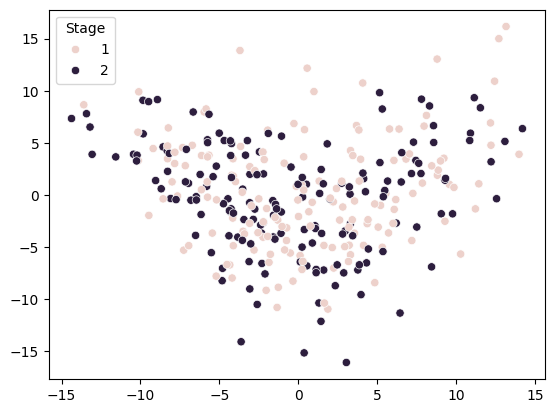

In [7]:
sns.scatterplot( x = x_pca[:,0] , y = x_pca[:,1], hue = y )

The goal of this project is to discover which CpG marker are the most diagnostic for cancer stage.

As such, the objective is not so much to build a good model than to interpret it and test if your putative biomarkers are enough to predict cancer stage.

> Remember to respect ML best practices (train/test separation, cross-validation, use adapted metrics, ...)

In [8]:
## load all necessary libraries from scikit
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import (
    roc_curve, auc as sklearn_auc,
    precision_recall_curve, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report,f1_score,RocCurveDisplay,roc_auc_score
)
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
#from catboost import CatBoostClassifier
import os


In [9]:
# confusion matrix 
def plot_confmat(y_true, y_pred, title="Confusion matrix",savepath=None):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_true))
    ax = disp.plot(values_format="d").ax_
    ax.set_xlabel("Predicted label", fontsize=11)
    ax.set_ylabel("True label", fontsize=11)
    ax.set_title(title)
    plt.xticks(rotation=30,ha='right',fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()

    # SAVE
    if savepath is not None:
        os.makedirs(savepath, exist_ok=True)
        fname = title.replace(" ", "_").lower()
        plt.savefig(
        os.path.join(savepath, f"{fname}.pdf"),
        dpi=300,
        bbox_inches="tight")
        os.makedirs(savepath, exist_ok=True)
        fname = title.replace(" ", "_").lower()
        plt.savefig(
        os.path.join(savepath, f"{fname}.jpg"),
        dpi=300,
        bbox_inches="tight")
        plt.show()


In [10]:
# AUC-ROC curves
def plot_roc_if_binary(model, X_test, y_test, title="ROC",savepath=None):
    classes = np.unique(y_test)
    if len(classes) != 2:
        return
    # prob for positive class (classes[1])
    y_prob = model.predict(X_test)
    auc = roc_auc_score(y_test, y_prob)

    # Probabilities for ROC/PR
    proba = model.predict(X_test)
    pred  = (proba >= 0.5).astype(int)

    print(classification_report(y_test, pred, digits=3))
    # PR
    prec, rec, _ = precision_recall_curve(y_test, proba)
    ap = average_precision_score(y_test, proba)
    # ROC
    fpr, tpr, _ = roc_curve(y_test, proba)
    roc_auc = sklearn_auc(fpr, tpr)
    RocCurveDisplay.from_predictions(y_test, y_prob)
    plt.title(f"{title} (AUC={auc:.3f})")
    plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
    plt.plot([0,1],[0,1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    # SAVE
    if savepath is not None:
        os.makedirs(savepath, exist_ok=True)
        fname = title.replace(" ", "_").lower()
        plt.savefig(
            os.path.join(savepath, f"{fname}.pdf"),
            dpi=300,
            bbox_inches="tight")
        plt.savefig(
            os.path.join(savepath, f"{fname}.jpg"),
            dpi=300,
            bbox_inches="tight")
        plt.show()



In [11]:
# do imputing and scaling of data
preprocess = [
    ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
    ("scaler", StandardScaler())]

In [12]:
import pandas as pd

# Assuming X is your DataFrame of features
corr_matrix = X.corr().abs()  # absolute value of correlation

upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
print("Features to drop due to high correlation:", to_drop)
X_reduced = X.drop(columns=to_drop)

Features to drop due to high correlation: ['cg12459759', 'cg02210967', 'cg12193943', 'cg19784198', 'cg14649566', 'cg17472664', 'cg18113826', 'cg11496569']


In [13]:
# splitting traing and test, along with a validation set from training set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
#y_train=y_train-1
#y_test=y_test-1

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

In [14]:
pipe=  Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("clf", XGBClassifier(
            n_estimators=400,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            objective="binary:logistic",
            eval_metric="mlogloss",
            random_state=42,
            n_jobs=-1,
            #num_class=2
        ))
])

In [15]:
param_grids = {
        "clf__n_estimators": [200, 400],
        "clf__max_depth": [4, 6],
        "clf__learning_rate": [0.05, 0.1],
        "clf__subsample": [0.8],
        "clf__colsample_bytree": [0.8]
}

In [16]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

base_pipe = pipe
grid = param_grids
gs = GridSearchCV(
        base_pipe,
        param_grid=grid,
        scoring="f1_macro",
        cv=cv,
        n_jobs=-1)

gs.fit(X_train, y_train_enc)

print("Best CV macro-F1:", round(gs.best_score_, 3))
print("Best params:", gs.best_params_)

Best CV macro-F1: 0.504
Best params: {'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.1, 'clf__max_depth': 6, 'clf__n_estimators': 200, 'clf__subsample': 0.8}



XGB TEST macro-F1 = 0.5772
              precision    recall  f1-score   support

           0      0.567     0.548     0.557        31
           1      0.588     0.606     0.597        33

    accuracy                          0.578        64
   macro avg      0.577     0.577     0.577        64
weighted avg      0.578     0.578     0.578        64



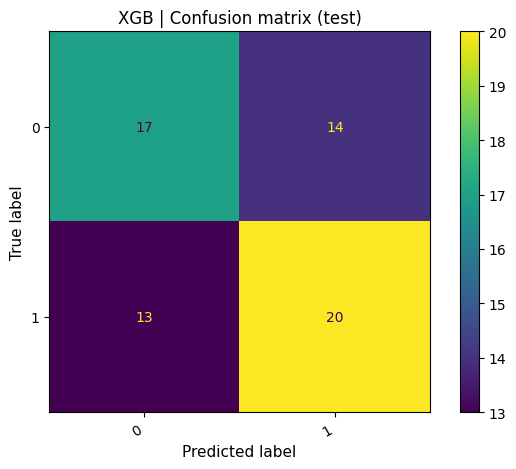

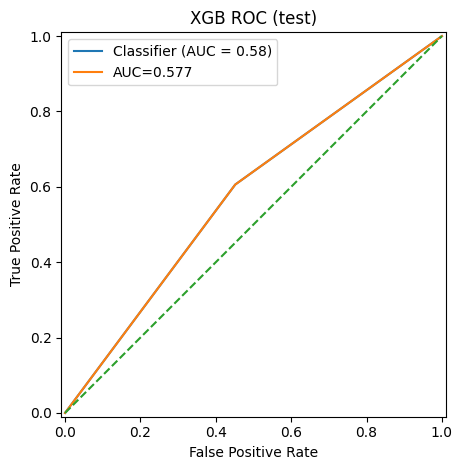

In [21]:
best_pipe = gs.best_estimator_
name='XGB'
y_pred = best_pipe.predict(X_test)
mf1 = f1_score(y_test_enc, y_pred, average="macro")

print("\n" + "="*70)
print(name, "TEST macro-F1 =", round(mf1, 4))

plot_confmat(y_test_enc, y_pred, title=f"{name} | Confusion matrix (test)", savepath=None)
plot_roc_if_binary(best_pipe, X_test, y_test_enc, title=f"{name} ROC (test)")


In [22]:
import shap
def shap_xgb(best_pipe, X_train, X_test, feature_names, class_names):
    """
    Compute SHAP values for XGBoost classifier (binary or multiclass)
    """
    imputer = best_pipe.named_steps["imputer"]
    model   = best_pipe.named_steps["clf"]

    # Apply preprocessing
    Xtr = imputer.transform(X_train)
    Xte = imputer.transform(X_test)

    # Explainer
    explainer = shap.TreeExplainer(model)
    shap_vals = explainer.shap_values(Xte)

    # Normalize output format to (n_classes, n_samples, n_features)
    if isinstance(shap_vals, list):
        shap_arr = np.stack(shap_vals, axis=0)  # multiclass
    else:
        shap_arr = np.asarray(shap_vals)
        if shap_arr.ndim == 2:
            # Binary: add class dimension
            shap_arr = shap_arr[np.newaxis, :, :]  # shape (1, n_samples, n_features)
        elif shap_arr.ndim == 3 and shap_arr.shape[-1] == len(class_names):
            shap_arr = np.transpose(shap_arr, (2, 0, 1))

    n_classes = len(class_names)

    # Per-class SHAP (mean(|SHAP|) for multiclass, raw SHAP for binary)
    per_class = {}
    if n_classes == 2:
        # Binary: explainer returns positive-class SHAP
        per_class[class_names[1]] = pd.Series(np.mean(shap_arr[0], axis=0), index=feature_names).sort_values(ascending=False)
        per_class[class_names[0]] = pd.Series(-np.mean(shap_arr[0], axis=0), index=feature_names).sort_values(ascending=False)
    else:
        # Multiclass
        for i, cls in enumerate(class_names):
            per_class[cls] = pd.Series(np.mean(np.abs(shap_arr[i]), axis=0), index=feature_names).sort_values(ascending=False)
    if n_classes == 2:
        overall = pd.Series(np.mean(np.abs(shap_arr[0]), axis=0), index=feature_names).sort_values(ascending=False)
    else:
        overall = pd.Series(np.mean(np.abs(shap_arr), axis=(0,1)), index=feature_names).sort_values(ascending=False)

    return overall, per_class, explainer, shap_arr, Xte


In [23]:
xgb_overall, xgb_per_class, explainer, shap_arr, Xte = shap_xgb(
    best_pipe,
    X_train,
    X_test,
    feature_names=X.columns,
    class_names=["1","2"]
)

print("Top 25 overall SHAP features:")
print(xgb_overall.head(25))

print("\nTop 20 features for each class:")
for cls, s in xgb_per_class.items():
    print("\n", cls)
    print(s.head(20))


Top 25 overall SHAP features:
cg05645404    0.619378
cg17975663    0.520829
cg11593482    0.259044
cg10376161    0.227711
cg01054938    0.176820
cg19171383    0.171190
cg11438560    0.166660
cg10931252    0.157763
cg05858136    0.157466
cg20246113    0.143410
cg07502417    0.142385
cg17385448    0.131816
cg08335389    0.128000
cg20187011    0.127324
cg01617071    0.124465
cg07753583    0.122091
cg14449251    0.120061
AGE           0.118080
cg01255747    0.114356
cg13421116    0.111213
cg22081096    0.111027
cg14525832    0.109164
cg04981696    0.107139
cg23173910    0.100414
cg14219620    0.083376
dtype: float32

Top 20 features for each class:

 2
cg17975663    0.100611
cg05645404    0.093760
cg01654582    0.047326
cg01054938    0.044210
cg19171383    0.035429
cg06799735    0.025569
cg20246113    0.023378
cg11593482    0.022876
cg11438560    0.022561
cg10797850    0.017481
cg05858136    0.014795
cg19291355    0.014487
cg26831416    0.013880
cg07185587    0.013498
cg05176051    0.01339